## Data Leakage Prevention

**Issue:** Clustering on full dataset before train/test split causes data leakage.

**Incorrect Flow:**
1. Load full data
2. Create clusters using ALL data (uses test set information)
3. Split train/test
4. Train model

**Correct Flow:**
1. Load full data
2. Split train/test FIRST
3. Create clusters using ONLY training data
4. Apply cluster assignments to test set
5. Train model

This ensures the model never sees test data during clustering.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score  # noqa: E402
import pickle
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ============================================================================
# GPU/CUDA CONFIGURATION
# ============================================================================

print(f"PyTorch version: {torch.__version__}")

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"\nGPU AVAILABLE: {torch.cuda.device_count()} GPU(s) detected")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.1f} GB")
    print(f"\nUsing device: {device}")
else:
    print("\nNo GPU detected - training will use CPU (slower)")
    print(f"Using device: {device}")

print("\nLibraries loaded")

PyTorch version: 2.9.1+cpu

No GPU detected - training will use CPU (slower)
Using device: cpu

Libraries loaded


## Step 1: Load Preprocessed Data

In [2]:
df = pd.read_csv("sales_data_up_to_2025_04_23.csv")
df['created_at'] = pd.to_datetime(df['created_at'])
df['day'] = df['created_at'].dt.date
last_sales_date = df['day'].max()
last_month = last_sales_date.replace(day=1)
df = df[df['day'] < last_month]
df = df[["day", "sku", "qty_ordered"]]
df_grouped = df.groupby(["day", "sku"]).agg({"qty_ordered": "sum"}).reset_index()

active_skus = pd.read_csv("always_active_skus.csv")
remaining_skus = df_grouped[df_grouped['sku'].isin(active_skus['sku'])]

min_sales_days = 31
sku_stats = remaining_skus.groupby('sku')['day'].agg(['min', 'max']).reset_index()
sku_stats.columns = ['sku', 'first_sale', 'last_sale']
sku_stats['first_sale'] = pd.to_datetime(sku_stats['first_sale'])
sku_stats['last_sale'] = pd.to_datetime(sku_stats['last_sale'])
filtered_skus = sku_stats[(sku_stats['last_sale'] - sku_stats['first_sale']).dt.days > min_sales_days]
remaining_skus = remaining_skus[remaining_skus["sku"].isin(filtered_skus["sku"])]

remaining_skus['day'] = pd.to_datetime(remaining_skus['day'])
global_start = remaining_skus['day'].min()
global_end = remaining_skus['day'].max()
sku_start_dates = remaining_skus.groupby('sku')['day'].min().rename('first_sale_date')

all_dates = pd.date_range(start=global_start, end=global_end, freq='D')
all_skus = remaining_skus['sku'].unique()
full_index = pd.MultiIndex.from_product([all_dates, all_skus], names=['day', 'sku'])

clean_sales = remaining_skus.groupby(['day', 'sku'])['qty_ordered'].sum()
df_lifecycle = clean_sales.reindex(full_index, fill_value=0).reset_index()
df_lifecycle = df_lifecycle.merge(sku_start_dates, on='sku', how='left')
df_lifecycle = df_lifecycle[df_lifecycle['day'] >= df_lifecycle['first_sale_date']]
df_lifecycle = df_lifecycle.drop(columns=['first_sale_date']).sort_values(by=['sku', 'day'])

print(F"Data loaded: {len(df_lifecycle)} rows, {df_lifecycle['sku'].nunique()} SKUs")

Data loaded: 4897095 rows, 12645 SKUs


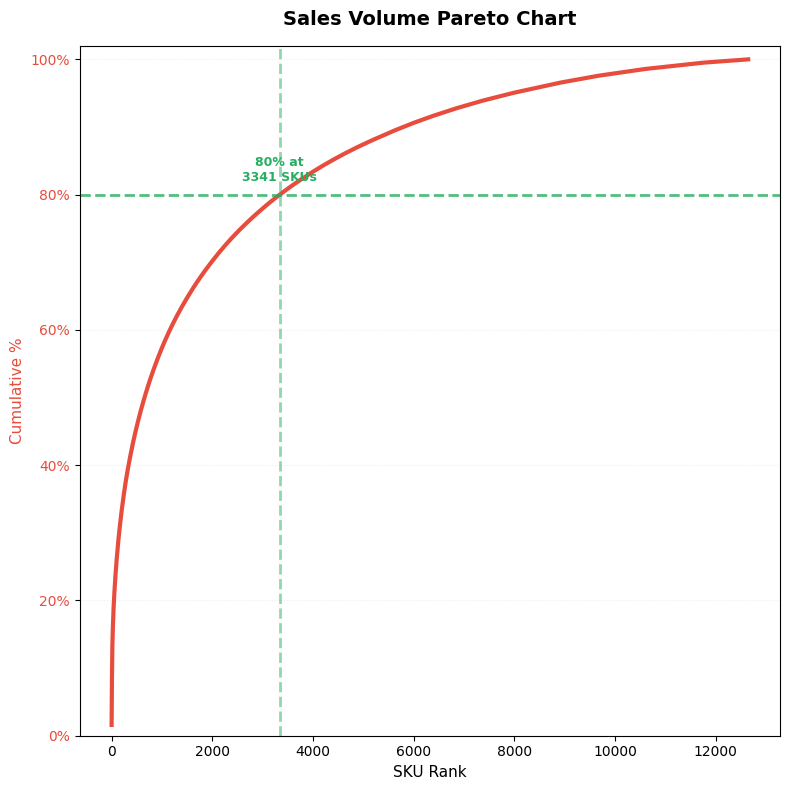

3341 SKUs (26.4%) drive 80% of total sales


In [3]:
# Pareto Distribution Chart: SKU Contribution to Total Sales

# Calculate total sales per SKU and sort
sku_volumes = df_lifecycle.groupby('sku')['qty_ordered'].sum().sort_values(ascending=False)
total_sales = sku_volumes.sum()

# Calculate cumulative percentage for ALL SKUs
cumsum_pct = (sku_volumes.cumsum() / total_sales) * 100

# Create figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot cumulative line for all SKUs
x_pos = np.arange(len(sku_volumes))
ax.plot(x_pos, cumsum_pct.values, color='#E74C3C', linewidth=3)

# Add 80% reference line
ax.axhline(y=80, color='#27AE60', linestyle='--', linewidth=2, alpha=0.8)

# Find where we cross 80%
cross_80_idx = np.where(cumsum_pct.values >= 80)[0]
if len(cross_80_idx) > 0:
    cross_idx = cross_80_idx[0]
    ax.axvline(x=cross_idx, color='#27AE60', linestyle='--', linewidth=2, alpha=0.5)
    ax.text(cross_idx, 82, f'80% at\n{cross_idx+1} SKUs', 
            ha='center', fontsize=9, color='#27AE60', fontweight='bold')

# Clean labels
ax.set_xlabel('SKU Rank', fontsize=11)
ax.set_ylabel('Cumulative %', fontsize=11, color='#E74C3C')

ax.tick_params(axis='y', labelcolor='#E74C3C')
ax.set_ylim(0, 102)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Simple title
plt.title('Sales Volume Pareto Chart', fontsize=14, fontweight='bold', pad=15)

# Minimal grid
ax.grid(axis='y', alpha=0.2, linestyle=':')

plt.tight_layout()
plt.show()

# Summary
print(f"{cross_80_idx[0]+1} SKUs ({(cross_80_idx[0]+1)/len(sku_volumes)*100:.1f}%) drive 80% of total sales")

In [4]:
# Apply Pareto Principle: Focus on top SKUs that represent 80% of sales
print("\n" + "="*70)
print("  FILTERING TO CLASS A SKUs (80% of Sales Volume)")
print("="*70)

# Calculate total sales per SKU
sku_total_sales = df_lifecycle.groupby('sku')['qty_ordered'].sum().sort_values(ascending=False)
total_sales = sku_total_sales.sum()

# Calculate cumulative percentage
sku_cumsum = sku_total_sales.cumsum()
sku_cumsum_pct = (sku_cumsum / total_sales) * 100

# Find SKUs that make up 80% of sales
class_a_threshold = 80
class_a_skus = sku_cumsum_pct[sku_cumsum_pct <= class_a_threshold].index.tolist()

# Also include the next SKU that pushes us just over 80% (more inclusive)
if len(class_a_skus) < len(sku_cumsum_pct):
    next_sku_idx = len(class_a_skus)
    class_a_skus.append(sku_cumsum_pct.index[next_sku_idx])

# Filter dataframe
df_lifecycle_original = df_lifecycle.copy()  # Keep backup
df_lifecycle = df_lifecycle[df_lifecycle['sku'].isin(class_a_skus)].copy()

# Calculate statistics
n_class_a = len(class_a_skus)
n_total = df_lifecycle_original['sku'].nunique()
pct_skus = (n_class_a / n_total) * 100
volume_class_a = df_lifecycle['qty_ordered'].sum()
volume_total = df_lifecycle_original['qty_ordered'].sum()
pct_volume = (volume_class_a / volume_total) * 100

print("\n Class A SKU Selection:")
print(f"  Total SKUs in data:        {n_total:,}")
print(f"  Class A SKUs (selected):   {n_class_a:,} ({pct_skus:.1f}% of all SKUs)")
print(f"  Class B+C SKUs (excluded): {n_total - n_class_a:,} ({100-pct_skus:.1f}% of all SKUs)")
print("\n Sales Volume Coverage:")
print(f"  Class A volume:            {volume_class_a:,.0f} units ({pct_volume:.2f}%)")
print(f"  Total volume:              {volume_total:,.0f} units")
print(f"\n Focusing on the {pct_skus:.1f}% of SKUs that drive {pct_volume:.1f}% of sales")
print("   This enables faster experimentation and better model optimization")
print("="*70)

# Show distribution of top SKUs
print("\nTop 10 SKUs by Volume:")
top_10 = sku_total_sales.head(10)
for i, (sku, vol) in enumerate(top_10.items(), 1):
    cumsum_pct = (sku_cumsum[sku] / total_sales) * 100
    print(f"  {i:2d}. SKU {sku}: {vol:>10,.0f} units (cumulative: {cumsum_pct:>5.2f}%)")

print(f"\nFiltered dataset: {len(df_lifecycle):,} rows, {df_lifecycle['sku'].nunique():,} Class A SKUs")


  FILTERING TO CLASS A SKUs (80% of Sales Volume)

 Class A SKU Selection:
  Total SKUs in data:        12,645
  Class A SKUs (selected):   3,341 (26.4% of all SKUs)
  Class B+C SKUs (excluded): 9,304 (73.6% of all SKUs)

 Sales Volume Coverage:
  Class A volume:            292,875 units (80.00%)
  Total volume:              366,084 units

 Focusing on the 26.4% of SKUs that drive 80.0% of sales
   This enables faster experimentation and better model optimization

Top 10 SKUs by Volume:
   1. SKU 7252908:      5,846 units (cumulative:  1.60%)
   2. SKU 7259986:      5,072 units (cumulative:  2.98%)
   3. SKU AltruistSPF30200SINGLE:      3,986 units (cumulative:  4.07%)
   4. SKU 7252924:      3,607 units (cumulative:  5.06%)
   5. SKU 7314799:      3,601 units (cumulative:  6.04%)
   6. SKU AltruistSPF50100SINGLE:      3,046 units (cumulative:  6.87%)
   7. SKU 7269399:      2,978 units (cumulative:  7.69%)
   8. SKU 7260018:      2,915 units (cumulative:  8.48%)
   9. SKU 7111765:   

## Filter to Class A SKUs (80% of Sales Volume)

Focus on high-volume SKUs first for faster iteration and better results where they matter most.

## Train/Test Split (BEFORE Clustering to Avoid Leakage)

In [ ]:
# Split BEFORE clustering to prevent data leakage
max_date = df_lifecycle['day'].max()
cutoff_date = max_date - pd.DateOffset(months=3)

df_train = df_lifecycle[df_lifecycle['day'] <= cutoff_date].copy()
df_test = df_lifecycle[df_lifecycle['day'] > cutoff_date].copy()

print(f"Training period: {df_train['day'].min().date()} to {df_train['day'].max().date()}")
print(f"Test period: {df_test['day'].min().date()} to {df_test['day'].max().date()}")
print(f"Training samples: {len(df_train):,}")
print(f"Test samples: {len(df_test):,}")
print("\nData split complete - clustering will use ONLY training data")

Training period: 2023-01-21 to 2024-12-31
Test period: 2025-01-01 to 2025-03-31
Training samples: 1,372,692
Test samples: 300,238

Data split complete - clustering will use ONLY training data


## Step 2: Rich Feature Engineering from Daily Data

In [ ]:
def extract_rich_features(df_data, sku, end_date, lookback_days=90):
    """
    Extract comprehensive features from daily data for a specific SKU
    
    Features:
    - Recent trends (7, 14, 30, 90 days)
    - Intermittency (% of days with sales)
    - Volatility (CV of daily sales)
    - Momentum (recent vs historical average)
    - Seasonal indices
    - Day-of-week patterns
    - Holt-Winters forecast (ensemble feature)
    """
    sku_data = df_data[df_data['sku'] == sku].copy()
    sku_data = sku_data[sku_data['day'] <= end_date].sort_values('day')
    
    if len(sku_data) == 0:
        return None
    
    features = {}
    
    # ==== RECENT TREND FEATURES ====
    for window in [7, 14, 30, 90]:
        recent_data = sku_data.tail(window)
        features[f'avg_{window}d'] = recent_data['qty_ordered'].mean()
        features[f'sum_{window}d'] = recent_data['qty_ordered'].sum()
        features[f'max_{window}d'] = recent_data['qty_ordered'].max()
        features[f'std_{window}d'] = recent_data['qty_ordered'].std()
    
    # ==== INTERMITTENCY ====
    recent_90 = sku_data.tail(90)
    features['intermittency'] = (recent_90['qty_ordered'] > 0).sum() / len(recent_90)
    
    # ==== VELOCITY CHANGE (Momentum) ====
    last_30 = sku_data.tail(30)['qty_ordered'].mean()
    prev_30 = sku_data.tail(60).head(30)['qty_ordered'].mean()
    features['momentum'] = (last_30 - prev_30) / (prev_30 + 1)  # % change
    
    # ==== VOLATILITY ====
    features['cv'] = sku_data['qty_ordered'].std() / (sku_data['qty_ordered'].mean() + 1)
    
    # ==== DAY OF WEEK PATTERNS ====
    sku_data['dow'] = sku_data['day'].dt.dayofweek
    dow_avg = sku_data.groupby('dow')['qty_ordered'].mean()
    for dow in range(7):
        features[f'dow_{dow}'] = dow_avg.get(dow, 0)
    
    # ==== SEASONAL FEATURES ====
    sku_data['month'] = sku_data['day'].dt.month
    monthly = sku_data.groupby('month')['qty_ordered'].sum()
    overall_monthly_avg = monthly.mean()
    
    # Current month and next 3 months seasonal indices
    current_month = end_date.month
    for i in range(4):  # Current + next 3 months
        month = ((current_month + i - 1) % 12) + 1
        seasonal_index = monthly.get(month, overall_monthly_avg) / (overall_monthly_avg + 1)
        features[f'seasonal_m{i}'] = seasonal_index
    
    # ==== COMPANY BASELINE: 12-MONTH AVERAGE ====
    # This is the company's current forecasting method
    last_12mo = sku_data.tail(365)  # Approximately 12 months
    if len(last_12mo) > 0:
        # Calculate actual months available
        actual_months = len(last_12mo) / 30.44
        
        # If we have 12+ months, divide by 12. Otherwise divide by actual months.
        if actual_months >= 12:
            baseline_12mo = last_12mo['qty_ordered'].sum() / 12
        else:
            baseline_12mo = last_12mo['qty_ordered'].sum() / max(actual_months, 1)
    else:
        baseline_12mo = 0
    features['baseline_12mo'] = baseline_12mo
    
    # ==== HOLT-WINTERS FORECAST (Ensemble Feature) ====
    try:
        monthly_data = sku_data.set_index('day').resample('MS')['qty_ordered'].sum()
        if len(monthly_data) >= 24:
            model = ExponentialSmoothing(
                monthly_data, 
                trend='add', 
                seasonal='add', 
                seasonal_periods=12
            ).fit()
            hw_forecast = model.forecast(3).mean()
        elif len(monthly_data) >= 12:
            model = ExponentialSmoothing(monthly_data, trend='add').fit()
            hw_forecast = model.forecast(3).mean()
        else:
            hw_forecast = monthly_data.tail(12).mean()
        features['hw_forecast'] = hw_forecast
    except:
        features['hw_forecast'] = sku_data.tail(90)['qty_ordered'].mean() * 30
    
    # ==== LIFECYCLE FEATURES ====
    features['days_since_first_sale'] = (end_date - sku_data['day'].min()).days
    features['total_sales_history'] = sku_data['qty_ordered'].sum()
    
    return features

print("Feature extraction function defined")

Feature extraction function defined


## Step 3: Improved Clustering (Multi-Dimensional)


COMPUTING CLUSTERING METRICS FOR VISUALIZATION
Note: This is for analysis purposes only. Using k=10 (hardcoded)
Loading metrics from checkpoint: checkpoint_k_optimization.pkl


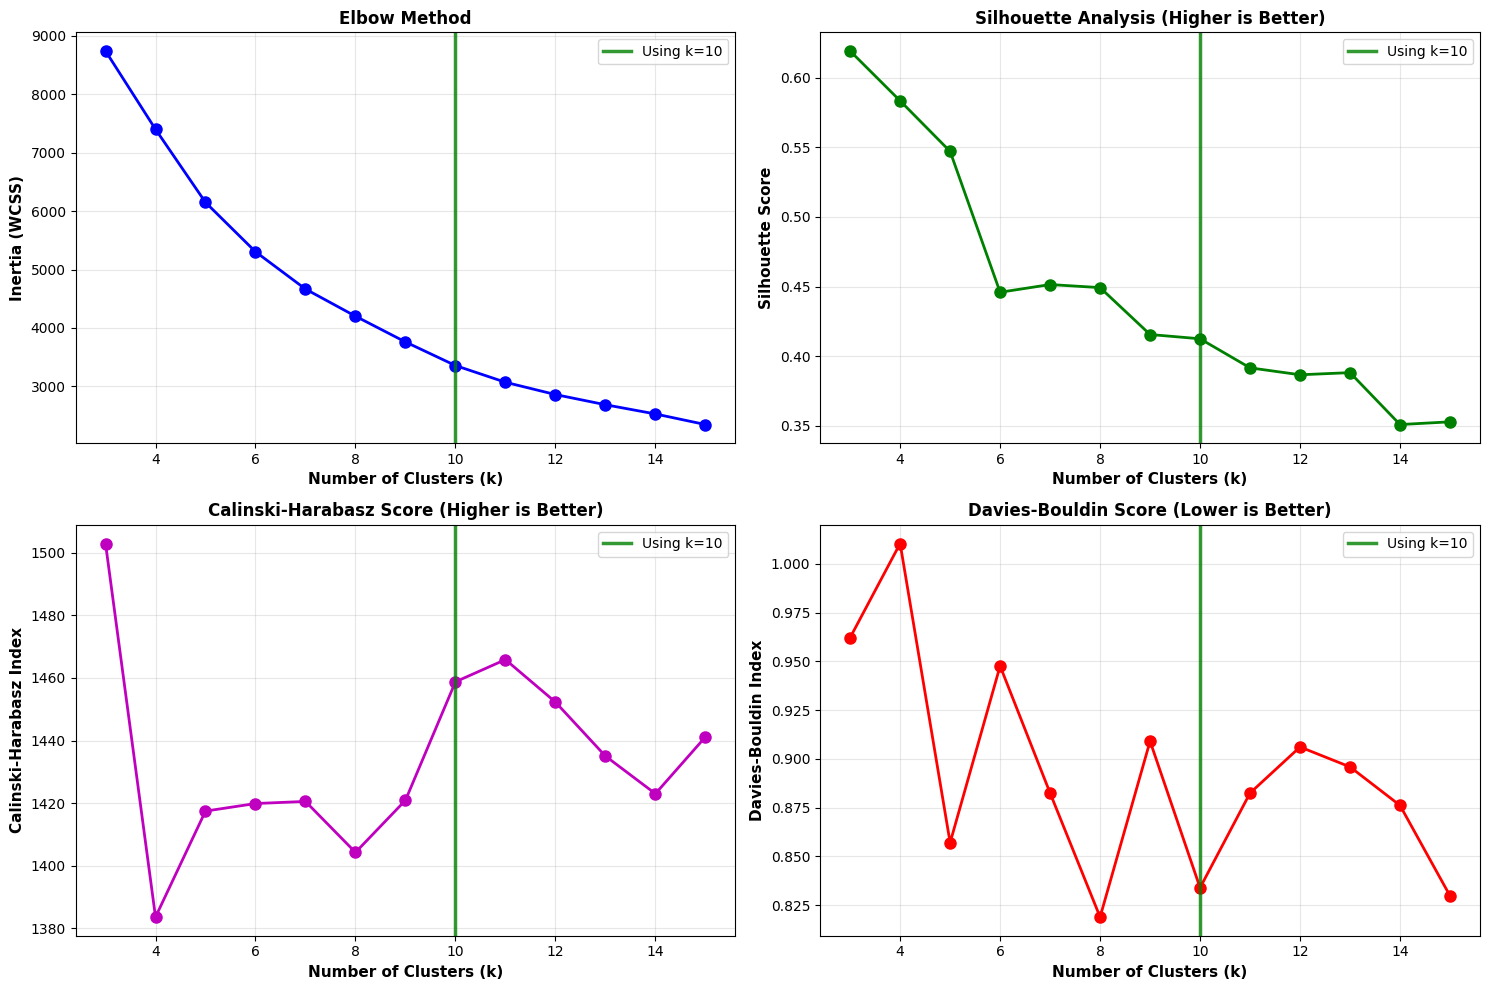


Clustering Metrics Table:
 k     inertia  silhouette  calinski_harabasz  davies_bouldin
 3 8739.316531    0.619289        1502.967299        0.962175
 4 7399.640245    0.583492        1383.625291        1.010444
 5 6148.708554    0.547125        1417.476220        0.856980
 6 5304.262732    0.445908        1419.891943        0.947631
 7 4665.694171    0.451452        1420.563509        0.882429
 8 4201.133407    0.449243        1404.282580        0.818831
 9 3760.493906    0.415540        1420.933503        0.909038
10 3356.968504    0.412466        1458.776500        0.833856
11 3070.520813    0.391583        1465.875345        0.882447
12 2860.275032    0.386602        1452.308139        0.906077
13 2686.147459    0.388143        1435.063267        0.895849
14 2528.065579    0.350833        1423.030372        0.876097
15 2346.996702    0.352781        1441.156997        0.829722

  USING k = 10 (Hardcoded)
  Metrics at k=10:
    Silhouette Score:     0.412
    Calinski-Harabasz:    

In [ ]:
def find_optimal_clusters(df_data, k_range=range(3, 16), sample_size=None):
    """
    Find optimal number of clusters using multiple metrics.
    
    Args:
        df_data: Training data (to prevent data leakage)
        k_range: Range of k values to test
        sample_size: Optional - sample SKUs for faster computation
    
    Returns:
        Dictionary with metrics for each k, and recommended k
    """
    # First, compute clustering features (same as create_smart_clusters)
    clustering_features = []
    skus = df_data['sku'].unique()
    
    # Optionally sample for speed (if dataset is very large)
    if sample_size and len(skus) > sample_size:
        print(f"Sampling {sample_size} SKUs from {len(skus)} for k-finding (faster)")
        skus = np.random.choice(skus, size=sample_size, replace=False)
    
    print(f"Computing features for {len(skus)} SKUs to find optimal k...")
    for sku in tqdm(skus, desc="Computing features"):
        sku_data = df_data[df_data['sku'] == sku]
        
        total_vol = sku_data['qty_ordered'].sum()
        avg_daily = sku_data['qty_ordered'].mean()
        intermittency = (sku_data['qty_ordered'] > 0).sum() / len(sku_data)
        
        if len(sku_data) > 30:
            x = np.arange(len(sku_data))
            y = sku_data['qty_ordered'].values
            trend = np.polyfit(x, y, 1)[0]
        else:
            trend = 0
        
        sku_data_temp = sku_data.copy()
        sku_data_temp['month'] = sku_data_temp['day'].dt.month
        monthly = sku_data_temp.groupby('month')['qty_ordered'].mean()
        seasonality_strength = monthly.std() / (monthly.mean() + 1)
        cv = sku_data['qty_ordered'].std() / (avg_daily + 1)
        
        clustering_features.append({
            'sku': sku,
            'log_avg_daily': np.log1p(avg_daily),
            'intermittency': intermittency,
            'trend': trend,
            'seasonality': seasonality_strength,
            'cv': cv
        })
    
    df_features = pd.DataFrame(clustering_features)
    cluster_cols = ['log_avg_daily', 'intermittency', 'trend', 'seasonality', 'cv']
    X = df_features[cluster_cols].fillna(0).values
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Test different k values
    results = {
        'k': [],
        'inertia': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }
    
    print(f"\nTesting k from {min(k_range)} to {max(k_range)}...")
    for k in tqdm(k_range, desc="Testing k values"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        labels = kmeans.fit_predict(X_scaled)
        
        results['k'].append(k)
        results['inertia'].append(kmeans.inertia_)
        results['silhouette'].append(silhouette_score(X_scaled, labels))
        results['calinski_harabasz'].append(calinski_harabasz_score(X_scaled, labels))
        results['davies_bouldin'].append(davies_bouldin_score(X_scaled, labels))
    
    df_results = pd.DataFrame(results)
    
    print("\nMetrics computed for visualization purposes")
    
    return df_results

# ============================================================================
# Compute clustering metrics for visualization (k is hardcoded to 10 for A)
# ============================================================================
CHOSEN_K = 10

print("\nCOMPUTING CLUSTERING METRICS FOR VISUALIZATION")
print("=" * 70)
print(f"Note: This is for analysis purposes only. Using k={CHOSEN_K} (hardcoded)")
print("=" * 70)

# Check for k-optimization checkpoint
k_checkpoint_file = 'checkpoint_k_optimization.pkl'
if os.path.exists(k_checkpoint_file):
    print(f"Loading metrics from checkpoint: {k_checkpoint_file}")
    with open(k_checkpoint_file, 'rb') as f:
        k_checkpoint = pickle.load(f)
        k_results = k_checkpoint['results']
else:
    # Compute metrics (use sample for speed if needed)
    k_results = find_optimal_clusters(
        df_train, 
        k_range=range(3, 16),  # Test k from 3 to 15
        sample_size=5000 if len(df_train['sku'].unique()) > 5000 else None
    )
    
    # Save checkpoint
    print(f"\nSaving metrics checkpoint: {k_checkpoint_file}")
    with open(k_checkpoint_file, 'wb') as f:
        pickle.dump({
            'results': k_results
        }, f)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Elbow plot
axes[0, 0].plot(k_results['k'], k_results['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Inertia (WCSS)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(x=CHOSEN_K, color='green', linestyle='-', linewidth=2.5, alpha=0.8, label=f'Using k={CHOSEN_K}')
axes[0, 0].legend()

# Silhouette score
axes[0, 1].plot(k_results['k'], k_results['silhouette'], 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Silhouette Analysis (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(x=CHOSEN_K, color='green', linestyle='-', linewidth=2.5, alpha=0.8, label=f'Using k={CHOSEN_K}')
axes[0, 1].legend()

# Calinski-Harabasz
axes[1, 0].plot(k_results['k'], k_results['calinski_harabasz'], 'mo-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Calinski-Harabasz Index', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Calinski-Harabasz Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(x=CHOSEN_K, color='green', linestyle='-', linewidth=2.5, alpha=0.8, label=f'Using k={CHOSEN_K}')
axes[1, 0].legend()

# Davies-Bouldin
axes[1, 1].plot(k_results['k'], k_results['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Davies-Bouldin Index', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Davies-Bouldin Score (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(x=CHOSEN_K, color='green', linestyle='-', linewidth=2.5, alpha=0.8, label=f'Using k={CHOSEN_K}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Display metrics table
print("\nClustering Metrics Table:")
print(k_results.to_string(index=False))

# Use k hardcoded

print("\n" + "="*70)
print(f"  USING k = {CHOSEN_K} (Hardcoded)")
print("="*70)
print(f"  Metrics at k={CHOSEN_K}:")
k8_metrics = k_results[k_results['k'] == CHOSEN_K]
if len(k8_metrics) > 0:
    print(f"    Silhouette Score:     {k8_metrics['silhouette'].values[0]:.3f}")
    print(f"    Calinski-Harabasz:    {k8_metrics['calinski_harabasz'].values[0]:.1f}")
    print(f"    Davies-Bouldin:       {k8_metrics['davies_bouldin'].values[0]:.3f}")
    print(f"    Inertia:              {k8_metrics['inertia'].values[0]:.1f}")
print("="*70)

In [8]:
def create_smart_clusters(df_data, n_clusters=8):
    """
    Cluster on: Volume + Intermittency + Trend + Seasonality Strength
    Returns: (cluster_map, kmeans_model, scaler) for applying to test set
    """
    clustering_features = []
    skus = df_data['sku'].unique()
    
    print(f"Computing cluster features for {len(skus)} SKUs...")
    for sku in tqdm(skus, desc="Computing cluster features"):
        sku_data = df_data[df_data['sku'] == sku]
        
        # Volume
        total_vol = sku_data['qty_ordered'].sum()
        avg_daily = sku_data['qty_ordered'].mean()
        
        # Intermittency
        intermittency = (sku_data['qty_ordered'] > 0).sum() / len(sku_data)
        
        # Trend (linear regression slope)
        if len(sku_data) > 30:
            x = np.arange(len(sku_data))
            y = sku_data['qty_ordered'].values
            trend = np.polyfit(x, y, 1)[0]  # Slope
        else:
            trend = 0
        
        # Seasonality strength
        sku_data_temp = sku_data.copy()
        sku_data_temp['month'] = sku_data_temp['day'].dt.month
        monthly = sku_data_temp.groupby('month')['qty_ordered'].mean()
        seasonality_strength = monthly.std() / (monthly.mean() + 1)
        
        # Volatility
        cv = sku_data['qty_ordered'].std() / (avg_daily + 1)
        
        clustering_features.append({
            'sku': sku,
            'total_volume': total_vol,
            'avg_daily': avg_daily,
            'intermittency': intermittency,
            'trend': trend,
            'seasonality': seasonality_strength,
            'cv': cv
        })
    
    df_features = pd.DataFrame(clustering_features)
    
    # Log-transform volume (reduce scale effect)
    df_features['log_volume'] = np.log1p(df_features['total_volume'])
    df_features['log_avg_daily'] = np.log1p(df_features['avg_daily'])
    
    # Select features for clustering
    cluster_cols = ['log_avg_daily', 'intermittency', 'trend', 'seasonality', 'cv']
    X = df_features[cluster_cols].fillna(0)
    
    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    df_features['cluster'] = kmeans.fit_predict(X_scaled)
    
    print("\nClustering complete")
    print("\nCluster Distribution:")
    print(df_features['cluster'].value_counts().sort_index())
    
    print("\nCluster Profiles:")
    print(df_features.groupby('cluster')[['avg_daily', 'intermittency', 'seasonality']].mean().round(2))
    
    cluster_map = df_features[['sku', 'cluster']].set_index('sku')['cluster']
    return cluster_map, kmeans, scaler

# ============================================================================
# EXECUTION: Create clusters on TRAINING data only (prevent data leakage)
# ============================================================================

# Check for checkpoint
checkpoint_file = 'checkpoint_clusters.pkl'
if os.path.exists(checkpoint_file):
    print(f"\nLoading clusters from checkpoint: {checkpoint_file}")
    with open(checkpoint_file, 'rb') as f:
        checkpoint = pickle.load(f)
        cluster_assignments_train = checkpoint['cluster_assignments_train']
        kmeans_model = checkpoint['kmeans_model']
        cluster_scaler = checkpoint['cluster_scaler']
        cluster_assignments_test = checkpoint['cluster_assignments_test']
        cluster_assignments = checkpoint['cluster_assignments']
    print(f"  Training SKUs: {len(cluster_assignments_train)}")
    print(f"  Test SKUs: {len(cluster_assignments_test)}")
    print(f"  Total SKUs: {len(cluster_assignments)}")
else:
    print("\nStep 4: Clustering on training data...")
    print(f"Using k = {CHOSEN_K} (hardcoded)")
    cluster_assignments_train, kmeans_model, cluster_scaler = create_smart_clusters(df_train, n_clusters=CHOSEN_K)

    # Apply cluster model to TEST data (no re-fitting!)
    print("\nApplying cluster model to test data...")
    test_skus = df_test['sku'].unique()
    test_clustering_features = []

    for sku in tqdm(test_skus, desc="Processing test SKUs"):
        sku_data = df_test[df_test['sku'] == sku]
        
        total_vol = sku_data['qty_ordered'].sum()
        avg_daily = sku_data['qty_ordered'].mean()
        intermittency = (sku_data['qty_ordered'] > 0).sum() / len(sku_data)
        
        if len(sku_data) > 30:
            x = np.arange(len(sku_data))
            y = sku_data['qty_ordered'].values
            trend = np.polyfit(x, y, 1)[0]
        else:
            trend = 0
        
        sku_data_temp = sku_data.copy()
        sku_data_temp['month'] = sku_data_temp['day'].dt.month
        monthly = sku_data_temp.groupby('month')['qty_ordered'].mean()
        seasonality_strength = monthly.std() / (monthly.mean() + 1)
        cv = sku_data['qty_ordered'].std() / (avg_daily + 1)
        
        test_clustering_features.append({
            'sku': sku,
            'log_avg_daily': np.log1p(avg_daily),
            'intermittency': intermittency,
            'trend': trend,
            'seasonality': seasonality_strength,
            'cv': cv
        })

    df_test_features = pd.DataFrame(test_clustering_features)
    cluster_cols = ['log_avg_daily', 'intermittency', 'trend', 'seasonality', 'cv']
    X_test = df_test_features[cluster_cols].fillna(0)
    X_test_scaled = cluster_scaler.transform(X_test)  # Use trained scaler
    df_test_features['cluster'] = kmeans_model.predict(X_test_scaled)  # Use trained model
    cluster_assignments_test = df_test_features[['sku', 'cluster']].set_index('sku')['cluster']

    # Combine train and test cluster assignments
    cluster_assignments = pd.concat([cluster_assignments_train, cluster_assignments_test])
    
    # Save checkpoint
    print(f"\n Saving checkpoint: {checkpoint_file}")
    with open(checkpoint_file, 'wb') as f:
        pickle.dump({
            'cluster_assignments_train': cluster_assignments_train,
            'kmeans_model': kmeans_model,
            'cluster_scaler': cluster_scaler,
            'cluster_assignments_test': cluster_assignments_test,
            'cluster_assignments': cluster_assignments
        }, f)
    
    print(f"\nTotal SKUs clustered: {len(cluster_assignments)}")
    print(f"  Training SKUs: {len(cluster_assignments_train)}")
    print(f"  Test SKUs: {len(cluster_assignments_test)}")

# Display combined cluster distribution (Train + Test)
print("\n" + "="*70)
print("  COMBINED CLUSTER DISTRIBUTION (Training + Test)")
print("="*70)
combined_distribution = cluster_assignments.value_counts().sort_index()
print(combined_distribution)
print(f"\nTotal SKUs: {len(cluster_assignments):,}")
print("\nCluster sizes (percentage):")
for cluster_id, count in combined_distribution.items():
    percentage = (count / len(cluster_assignments)) * 100
    print(f"  Cluster {cluster_id}: {count:>6,} SKUs ({percentage:>5.1f}%)")
print("="*70)


Loading clusters from checkpoint: checkpoint_clusters.pkl
  Training SKUs: 3328
  Test SKUs: 3341
  Total SKUs: 6669

  COMBINED CLUSTER DISTRIBUTION (Training + Test)
cluster
0    1877
1     736
2       3
3     186
4       3
5      36
6      17
7       4
8      26
9    3781
Name: count, dtype: int64

Total SKUs: 6,669

Cluster sizes (percentage):
  Cluster 0:  1,877 SKUs ( 28.1%)
  Cluster 1:    736 SKUs ( 11.0%)
  Cluster 2:      3 SKUs (  0.0%)
  Cluster 3:    186 SKUs (  2.8%)
  Cluster 4:      3 SKUs (  0.0%)
  Cluster 5:     36 SKUs (  0.5%)
  Cluster 6:     17 SKUs (  0.3%)
  Cluster 7:      4 SKUs (  0.1%)
  Cluster 8:     26 SKUs (  0.4%)
  Cluster 9:  3,781 SKUs ( 56.7%)


## Step 4: Build Training Dataset

In [9]:
df_lifecycle_subset = df_lifecycle

In [10]:
def build_training_data(df_data, cluster_map, months_ahead=1):
    """
    OPTIMIZED VERSION: Uses groupby to avoid repeated full-table scans.
    """
    training_data = []
    
    # Get all month-ends for training
    all_months = pd.date_range(
        start=df_data['day'].min() + pd.DateOffset(months=12),
        end=df_data['day'].max() - pd.DateOffset(months=3),
        freq='MS'
    )
    
    skus = df_data['sku'].unique()
    
    # Optimization: Group data once
    print("Grouping data for faster access...")
    # This creates a dictionary-like structure where we can grab one SKU's data instantly
    df_grouped = df_data.groupby('sku')
    
    print(f"Building training data for {len(skus)} SKUs across {len(all_months)} months...")
    
    for sku in tqdm(skus, desc="Processing SKUs"):
        # Fast: Grab only this SKU's data immediately
        try:
            sku_df = df_grouped.get_group(sku)
        except KeyError:
            continue
            
        # Handle duplicate SKUs (same SKU in train+test)
        try:
            cluster_value = cluster_map.loc[sku]
            # Handle case where SKU appears multiple times (train + test)
            if hasattr(cluster_value, 'iloc'):
                cluster = int(cluster_value.iloc[0])
            else:
                cluster = int(cluster_value)
        except (KeyError, TypeError):
            cluster = 0
        
        for month_end in all_months:
            # Pass only the small 'sku_df' instead of the huge 'df_data'
            features = extract_rich_features(sku_df, sku, month_end)
            
            if features is None:
                continue
            
            # Search the small 'sku_df' instead of huge 'df_data'
            sku_future = sku_df[
                (sku_df['day'] > month_end) & 
                (sku_df['day'] <= month_end + pd.DateOffset(months=3))
            ]
            
            # Monthly targets
            for i in range(1, 4):  # Next 3 months
                month_start = month_end + pd.DateOffset(months=i)
                month_data = sku_future[
                    (sku_future['day'] >= month_start) & 
                    (sku_future['day'] < month_start + pd.DateOffset(months=1))
                ]
                
                target = month_data['qty_ordered'].sum()
                
                row = {
                    'sku': sku,
                    'cluster': cluster,
                    'month_end': month_end,
                    'forecast_horizon': i,
                    'target_month': month_start,
                    'target': target,
                    **features
                }
                
                training_data.append(row)
    
    df_train = pd.DataFrame(training_data)
    print(f"\nTraining samples created: {len(df_train)}")
    return df_train

# Check for checkpoint
training_checkpoint = 'checkpoint_training_data.pkl'
if os.path.exists(training_checkpoint):
    print(f"\nLoading training data from checkpoint: {training_checkpoint}")
    df_training = pd.read_pickle(training_checkpoint)
    print(f"  Samples: {len(df_training):,}")
    print(f"  Features: {len([c for c in df_training.columns if c not in ['sku', 'month_end', 'target_month', 'target', 'cluster', 'forecast_horizon']])}")
else:
    # Use subset for rapid testing (change to df_lifecycle for full run)
    print("\nTESTING MODE: Using subset of 100 high-volume SKUs")
    print("   (Change df_lifecycle_subset to df_lifecycle for full dataset)")
    df_training = build_training_data(df_lifecycle_subset, cluster_assignments, months_ahead=1)
    
    # Save checkpoint
    print(f"\nSaving checkpoint: {training_checkpoint}")
    df_training.to_pickle(training_checkpoint)
    print("  Checkpoint saved!")


Loading training data from checkpoint: checkpoint_training_data.pkl
  Samples: 93,843
  Features: 34


## Step 5: Train/Validation/Test Split (3-Way Split)

**Split Strategy:**
- **Training (60%)**: Fit model parameters
- **Validation (20%)**: Early stopping, hyperparameter tuning
- **Test (20%)**: Final evaluation - never touched during development

This prevents test set contamination and ensures unbiased evaluation metrics.

In [11]:
# 3-way time-based split: 60% train / 20% validation / 20% test
val_split_date = df_training['month_end'].quantile(0.6)   # First 60% for training
test_split_date = df_training['month_end'].quantile(0.8)  # Next 20% for validation, last 20% for test

train_data = df_training[df_training['month_end'] <= val_split_date].copy()
val_data = df_training[(df_training['month_end'] > val_split_date) & 
                       (df_training['month_end'] <= test_split_date)].copy()
test_data = df_training[df_training['month_end'] > test_split_date].copy()

print(f"\n{'='*70}")
print(f"  3-WAY DATA SPLIT")
print(f"{'='*70}")
print(f"Training samples:   {len(train_data):,} ({len(train_data)/len(df_training)*100:.1f}%)")
print(f"Validation samples: {len(val_data):,} ({len(val_data)/len(df_training)*100:.1f}%)")
print(f"Test samples:       {len(test_data):,} ({len(test_data)/len(df_training)*100:.1f}%)")
print(f"\nSplit dates:")
print(f"  Train end:      {val_split_date.date()}")
print(f"  Validation end: {test_split_date.date()}")
print(f"\nNote: Test set will only be used for final evaluation")
print(f"{'='*70}")


  3-WAY DATA SPLIT
Training samples:   64,464 (68.7%)
Validation samples: 19,446 (20.7%)
Test samples:       9,933 (10.6%)

Split dates:
  Train end:      2024-09-01
  Validation end: 2024-11-01

Note: Test set will only be used for final evaluation


## Step 6: Prepare Neural Network Inputs

In [ ]:
# Separate features - include forecast_horizon (critical for the model to know which month it's predicting)
feature_cols = [c for c in train_data.columns if c not in 
                ['sku', 'cluster', 'month_end', 'target_month', 'target']]

print("\nNote: forecast_horizon is included in features")
print("   The model can learn different behaviors for 1-month vs 3-month forecasts.")

X_train = train_data[feature_cols].values
y_train = train_data['target'].values
cluster_train = pd.to_numeric(train_data['cluster'], errors='coerce').fillna(0).astype(np.int64).values

X_val = val_data[feature_cols].values
y_val = val_data['target'].values
cluster_val = pd.to_numeric(val_data['cluster'], errors='coerce').fillna(0).astype(np.int64).values

X_test = test_data[feature_cols].values
y_test = test_data['target'].values
cluster_test = pd.to_numeric(test_data['cluster'], errors='coerce').fillna(0).astype(np.int64).values

# Don't scale baseline features - they're already in the target's scale
# Identify baseline feature indices
baseline_features = ['hw_forecast', 'baseline_12mo']
baseline_indices = [i for i, col in enumerate(feature_cols) if col in baseline_features]
other_indices = [i for i, col in enumerate(feature_cols) if col not in baseline_features]

print(f"\nBaseline features will NOT be scaled: {baseline_features}")
print("   This allows the model to directly copy baseline signals.")

# Scale only non-baseline features
scaler_X = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

if other_indices:
    X_train_scaled[:, other_indices] = scaler_X.fit_transform(X_train[:, other_indices])
    X_val_scaled[:, other_indices] = scaler_X.transform(X_val[:, other_indices])
    X_test_scaled[:, other_indices] = scaler_X.transform(X_test[:, other_indices])

# Use sqrt transform instead of log (gentler transformation)
print("\nUsing SQRT transform for target variable")
print("   sqrt is gentler - small errors in sqrt space don't explode like in log space.")
y_train_sqrt = np.sqrt(y_train)
y_val_sqrt = np.sqrt(y_val)
y_test_sqrt = np.sqrt(y_test)

# Check for NaN/Inf before tensor conversion
print("\nData quality checks:")
print(f"  X_train NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"  X_train Inf count: {np.isinf(X_train_scaled).sum()}")
print(f"  X_test NaN count: {np.isnan(X_test_scaled).sum()}")
print(f"  X_test Inf count: {np.isinf(X_test_scaled).sum()}")
print(f"  y_train_sqrt NaN count: {np.isnan(y_train_sqrt).sum()}")
print(f"  y_train_sqrt Inf count: {np.isinf(y_train_sqrt).sum()}")
print(f"  y_test_sqrt NaN count: {np.isnan(y_test_sqrt).sum()}")
print(f"  y_test_sqrt Inf count: {np.isinf(y_test_sqrt).sum()}")
print(f"  cluster_train unique values: {np.unique(cluster_train)}")

# Replace NaN/Inf with 0 if any exist
if np.isnan(X_train_scaled).any() or np.isinf(X_train_scaled).any():
    print("  Fixing NaN/Inf in X_train...")
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    X_val_scaled = np.nan_to_num(X_val_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)

if np.isnan(y_train_sqrt).any() or np.isinf(y_train_sqrt).any():
    print("  Fixing NaN/Inf in y_train_sqrt...")
    y_train_sqrt = np.nan_to_num(y_train_sqrt, nan=0.0, posinf=0.0, neginf=0.0)
    y_val_sqrt = np.nan_to_num(y_val_sqrt, nan=0.0, posinf=0.0, neginf=0.0)
    y_test_sqrt = np.nan_to_num(y_test_sqrt, nan=0.0, posinf=0.0, neginf=0.0)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_sqrt).unsqueeze(1).to(device)
cluster_train_tensor = torch.LongTensor(cluster_train).to(device)

X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val_sqrt).unsqueeze(1).to(device)
cluster_val_tensor = torch.LongTensor(cluster_val).to(device)

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_sqrt).unsqueeze(1).to(device)
cluster_test_tensor = torch.LongTensor(cluster_test).to(device)

print("\nFeature matrix shapes:")
print(f"  Training:   {X_train_scaled.shape}")
print(f"  Validation: {X_val_scaled.shape}")
print(f"  Test:       {X_test_scaled.shape}")
print(f"Target range: {y_train.min():.0f} to {y_train.max():.0f}")
print(f"Device: {device}")


Note: forecast_horizon is included in features
   The model can learn different behaviors for 1-month vs 3-month forecasts.

Baseline features will NOT be scaled: ['hw_forecast', 'baseline_12mo']
   This allows the model to directly copy baseline signals.

Using SQRT transform for target variable
   sqrt is gentler - small errors in sqrt space don't explode like in log space.

Data quality checks:
  X_train NaN count: 405
  X_train Inf count: 0
  X_test NaN count: 105
  X_test Inf count: 0
  y_train_sqrt NaN count: 0
  y_train_sqrt Inf count: 0
  y_test_sqrt NaN count: 0
  y_test_sqrt Inf count: 0
  cluster_train unique values: [0 1 2 3 4 5 8 9]
  Fixing NaN/Inf in X_train...

Feature matrix shapes:
  Training:   (64464, 35)
  Validation: (19446, 35)
  Test:       (9933, 35)
Target range: 0 to 1648
Device: cpu


## Step 7: Build Neural Network with Cluster Embeddings

In [13]:
class ForecastModel(nn.Module):
    """
    Simplified PyTorch neural network (64->32->16)
    - Dense layers for numerical features
    - Embedding layer for cluster information
    - Combined architecture
    """
    def __init__(self, n_features, n_clusters, embedding_dim=4):
        super(ForecastModel, self).__init__()
        
        # Cluster embedding
        self.cluster_embedding = nn.Embedding(n_clusters, embedding_dim)
        
        # Simplified architecture: 64->32->16
        self.fc1 = nn.Linear(n_features, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.15)
        
        # Combined layers (features + cluster embedding)
        self.fc3 = nn.Linear(32 + embedding_dim, 16)
        self.fc4 = nn.Linear(16, 1)
        
        # Activation
        self.relu = nn.ReLU()
        
    def forward(self, features, clusters):
        # Process features
        x = self.relu(self.fc1(features))
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x = self.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        
        # Process cluster embedding
        cluster_emb = self.cluster_embedding(clusters)
        
        # Combine
        combined = torch.cat([x, cluster_emb], dim=1)
        
        # Final layers
        z = self.relu(self.fc3(combined))
        output = self.fc4(z)
        
        return output

# Build model
model = ForecastModel(
    n_features=X_train_scaled.shape[1],
    n_clusters=cluster_assignments.nunique(),
    embedding_dim=4
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

ForecastModel(
  (cluster_embedding): Embedding(10, 4)
  (fc1): Linear(in_features=35, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.15, inplace=False)
  (fc3): Linear(in_features=36, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

Total parameters: 5,225
Trainable parameters: 5,225


## Step 8: Train the Model


Using MSE loss in sqrt-space
   MSE in sqrt-space is better aligned with MAPE in actual-space.
Loading model checkpoint: checkpoint_model_training.pt
  Resuming from epoch 59, best val loss: 0.9238
Starting training from epoch 60...
Using device: cpu
Epoch 60/100 - Loss: 0.7563 - Val Loss: 0.9356 - MAE: 0.5804 - Val MAE: 0.6473
Epoch 65/100 - Loss: 0.7600 - Val Loss: 0.9582 - MAE: 0.5805 - Val MAE: 0.6435
Epoch 70/100 - Loss: 0.7639 - Val Loss: 0.9728 - MAE: 0.5792 - Val MAE: 0.6453
Epoch 75/100 - Loss: 0.7604 - Val Loss: 0.9507 - MAE: 0.5794 - Val MAE: 0.6481

Early stopping at epoch 79

Training complete! Best validation loss: 0.9238


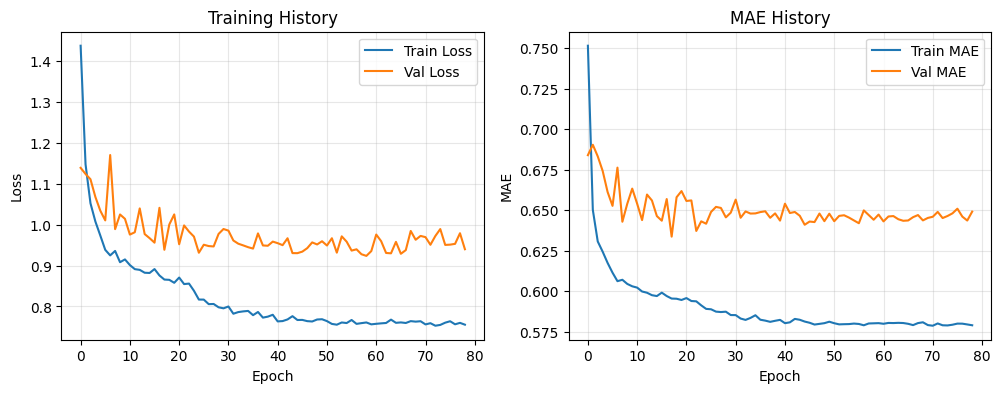

<Figure size 640x480 with 0 Axes>

In [14]:
# Training setup
# Use MSE loss (optimizes in sqrt-space which is closer to actual-space)
print("\nUsing MSE loss in sqrt-space")
print("   MSE in sqrt-space is better aligned with MAPE in actual-space.")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=0.00001)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, cluster_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, cluster_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Training loop with checkpointing
epochs = 100
best_val_loss = float('inf')
patience = 20
patience_counter = 0

history = {'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': []}

# Check for model checkpoint
model_checkpoint = 'checkpoint_model_training.pt'
if os.path.exists(model_checkpoint):
    print(f"Loading model checkpoint: {model_checkpoint}")
    checkpoint = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']
    best_val_loss = checkpoint['best_val_loss']
    best_model_state = checkpoint['best_model_state']
    print(f"  Resuming from epoch {start_epoch}, best val loss: {best_val_loss:.4f}")
else:
    start_epoch = 0
    best_model_state = model.state_dict().copy()

print(f"Starting training from epoch {start_epoch + 1}...")
print(f"Using device: {device}")

for epoch in range(start_epoch, epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    
    for X_batch, cluster_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        outputs = model(X_batch, cluster_batch)
        loss = criterion(outputs, y_batch)
        
        # Check for NaN loss
        if torch.isnan(loss):
            print(f"\nNaN loss detected at epoch {epoch+1}!")
            print(f"  outputs min/max: {outputs.min():.4f} / {outputs.max():.4f}")
            print(f"  y_batch min/max: {y_batch.min():.4f} / {y_batch.max():.4f}")
            print(f"  cluster_batch: {cluster_batch[:5]}")
            break
        
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        train_mae += torch.mean(torch.abs(outputs - y_batch)).item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_mae /= len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    
    with torch.no_grad():
        for X_batch, cluster_batch, y_batch in val_loader:
            outputs = model(X_batch, cluster_batch)
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item() * X_batch.size(0)
            val_mae += torch.mean(torch.abs(outputs - y_batch)).item() * X_batch.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_mae /= len(val_loader.dataset)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        
        # Save checkpoint when we get a better model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_model_state': best_model_state,
            'history': history
        }, model_checkpoint)
    else:
        patience_counter += 1
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - MAE: {train_mae:.4f} - Val MAE: {val_mae:.4f}")
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Restore best model
model.load_state_dict(best_model_state)
print(f"\nTraining complete! Best validation loss: {best_val_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE History')
plt.grid(True, alpha=0.3)

plt.show()
plt.tight_layout()

## Step 9: Evaluate on Test Set (Final Evaluation)

- Unbiased evaluation of model generalization
- Test set was never seen during training or early stopping

In [15]:
# Predict on test set (final unbiased evaluation)
model.eval()
with torch.no_grad():
    y_pred_sqrt_tensor = model(X_test_tensor, cluster_test_tensor)
    y_pred_sqrt = y_pred_sqrt_tensor.cpu().numpy().flatten()

y_pred = np.square(y_pred_sqrt)  # Inverse sqrt transform

# Calculate MAPE on test set
total_actual = y_test.sum()
total_error = np.abs(y_test - y_pred).sum()
weighted_mape = (total_error / total_actual) * 100

print(f"\n{'='*60}")
print("   NEURAL NETWORK RESULTS (TEST SET)")
print(f"{'='*60}")
print(f"  Weighted MAPE:      {weighted_mape:.2f}%")
print(f"  Total Actual:       {total_actual:,.0f}")
print(f"  Total Predicted:    {y_pred.sum():,.0f}")
print(f"  Bias:               {((y_pred.sum() - total_actual) / total_actual * 100):+.2f}%")
print(f"{'='*60}")


   NEURAL NETWORK RESULTS (TEST SET)
  Weighted MAPE:      87.59%
  Total Actual:       35,207
  Total Predicted:    37,880
  Bias:               +7.59%


## Step 10: Compare Against Baseline

In [16]:
# Baseline comparison: Company's current method (12-month average)
# Uses the feature from test set

print("\n" + "="*60)
print("  CALCULATING BASELINE ON TEST SET")
print("="*60)

# The 12-month baseline was already computed as a feature
# Note: baseline_12mo was NOT scaled, so use original X_test
baseline_12mo_col_idx = feature_cols.index('baseline_12mo')
baseline_12mo = X_test[:, baseline_12mo_col_idx]

print("Using pre-computed 12-month baseline feature from test set")

# Calculate MAPE for 12-month average baseline on test set
baseline_12mo_mape = (np.abs(y_test - baseline_12mo).sum() / total_actual) * 100

# Calculate baseline Total Predicted and Bias
baseline_total_predicted = baseline_12mo.sum()
baseline_bias = ((baseline_total_predicted - total_actual) / total_actual * 100)

# Print detailed baseline metrics (matching NN format)
print(f"\n{'='*60}")
print("   COMPANY BASELINE RESULTS (TEST SET)")
print(f"{'='*60}")
print(f"  Weighted MAPE:      {baseline_12mo_mape:.2f}%")
print(f"  Total Actual:       {total_actual:,.0f}")
print(f"  Total Predicted:    {baseline_total_predicted:,.0f}")
print(f"  Bias:               {baseline_bias:+.2f}%")
print(f"{'='*60}")

# Print comparison
print(f"\n{'='*60}")
print("   FINAL COMPARISON: NN vs Company Baseline (TEST SET)")
print(f"{'='*60}")
print(f"  Company Baseline (12mo avg):  {baseline_12mo_mape:.2f}%")
print(f"  Neural Network:               {weighted_mape:.2f}%")
print(f"  Improvement:                  {baseline_12mo_mape - weighted_mape:+.2f} pp")
print(f"  Relative Improvement:         {((baseline_12mo_mape - weighted_mape) / baseline_12mo_mape * 100):+.1f}%")
print(f"{'='*60}")


  CALCULATING BASELINE ON TEST SET
Using pre-computed 12-month baseline feature from test set

   COMPANY BASELINE RESULTS (TEST SET)
  Weighted MAPE:      127.36%
  Total Actual:       35,207
  Total Predicted:    56,418
  Bias:               +60.25%

   FINAL COMPARISON: NN vs Company Baseline (TEST SET)
  Company Baseline (12mo avg):  127.36%
  Neural Network:               87.59%
  Improvement:                  +39.77 pp
  Relative Improvement:         +31.2%


In [17]:
# Baseline forecast validation
print("\nBASELINE FORECAST VALUE:")
print(f"   Total Predicted: {baseline_12mo.sum():,.0f}")
print(f"   Total Actual:    {y_test.sum():,.0f}")
print(f"   Difference:      {(baseline_12mo.sum() - y_test.sum()):+,.0f}")


BASELINE FORECAST VALUE:
   Total Predicted: 56,418
   Total Actual:    35,207
   Difference:      +21,211


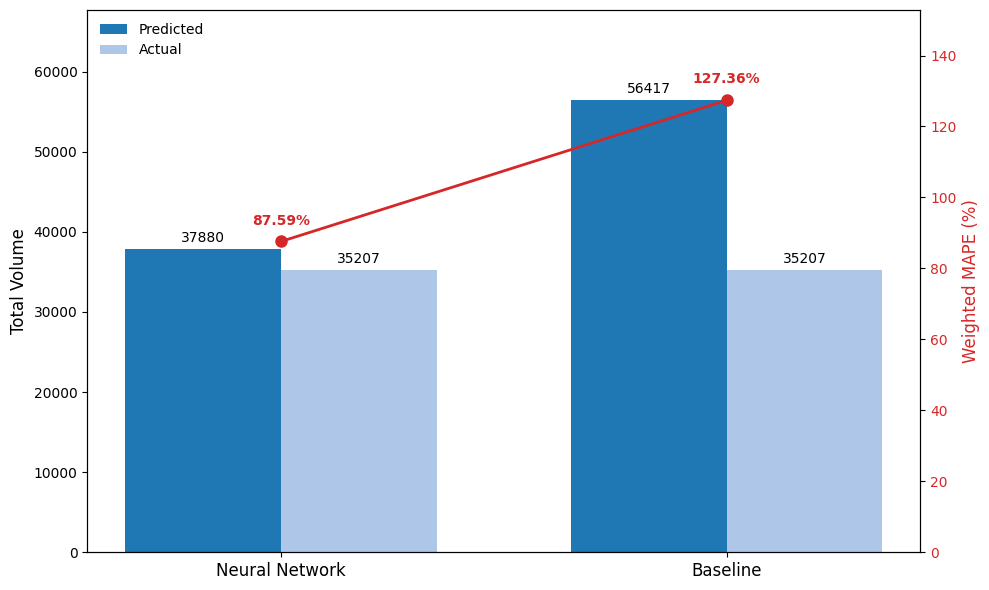

In [22]:
models = ['Neural Network', 'Baseline']
predicted = [y_pred.sum(), baseline_total_predicted]
actual_val = total_actual
actuals = [actual_val, actual_val]  # Same target for both
mape = [weighted_mape, baseline_12mo_mape]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Grouped Bars (Volume)
# Predicted
rects1 = ax1.bar(x - width/2, predicted, width, label='Predicted', color='#1f77b4')
# Actual
rects2 = ax1.bar(x + width/2, actuals, width, label='Actual', color='#aec7e8')  # Lighter blue for context

ax1.set_ylabel('Total Volume', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=12)
ax1.set_ylim(0, max(max(predicted), actual_val) * 1.2)  # Dynamic headroom
ax1.legend(loc='upper left', frameon=False)

# Plot Line (MAPE) on Secondary Axis
ax2 = ax1.twinx()
color_mape = '#d62728'
ax2.plot(x, mape, color=color_mape, marker='o', linewidth=2, markersize=8, linestyle='-', label='Weighted MAPE')
ax2.set_ylabel('Weighted MAPE (%)', color=color_mape, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color_mape)
ax2.set_ylim(0, max(mape) * 1.2)  # Dynamic y-limit based on actual MAPE values

def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Label for MAPE points
for i, val in enumerate(mape):
    ax2.annotate(f'{val:.2f}%',
                 xy=(i, val),
                 xytext=(0, 10), 
                 textcoords="offset points",
                 ha='center', va='bottom', color=color_mape, fontweight='bold')

plt.tight_layout()
plt.show()